=== 费根鲍姆/分形特征分析 (Hurst Exponent) ===
数据长度: 114154
计算素数 H...
计算 Logistic H...
计算随机噪声 H...


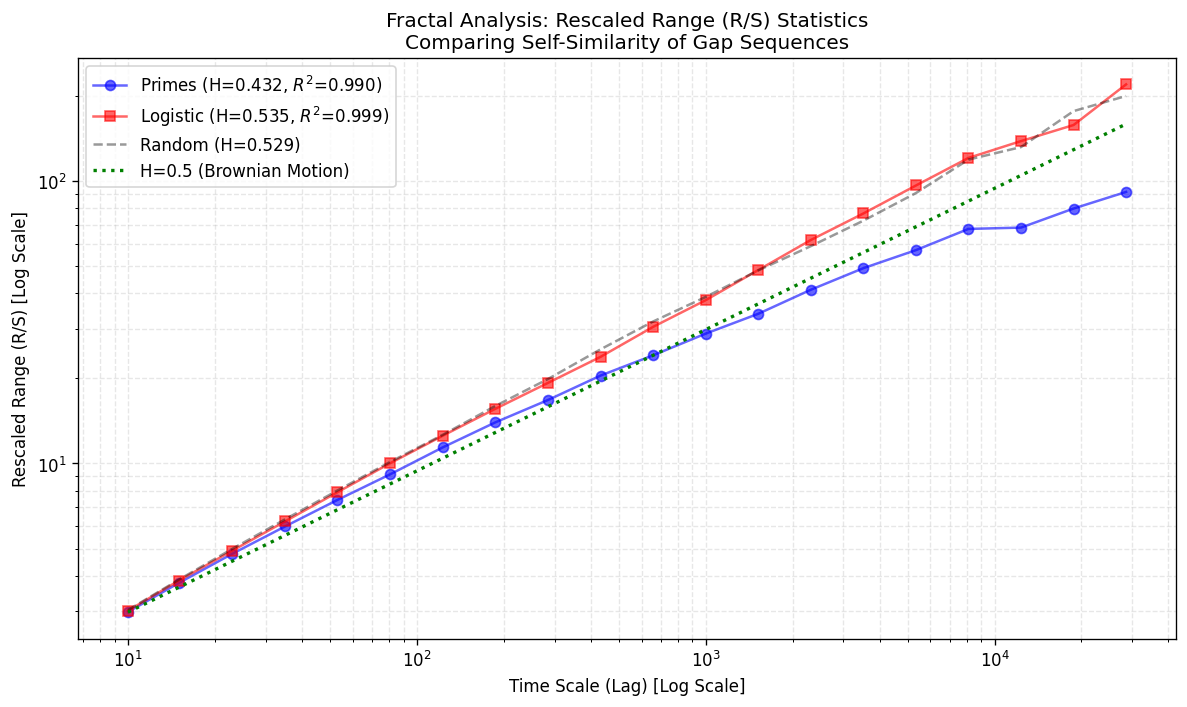

------------------------------
Primes Hurst   : 0.4324
Logistic Hurst : 0.5347
Random Hurst   : 0.5285

解读：
1. 如果 H < 0.5，说明系统具有'反持久性'（自我修正）。
   素数定理要求密度恒定，这本质上是一种自我修正机制。
2. 如果 Logistic 的 H 值与素数接近，说明两者具有相同的分形时间结构。
3. 这间接验证了两者共享某种受费根鲍姆常数 alpha 支配的几何缩放律。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ==========================================
# 1. 数据生成 (保持之前的逻辑)
# ==========================================
U_CRITICAL = 1.543689012692076 
DATA_LENGTH = 100_000 # R/S分析不需要特别长，但需要连续
PRIME_LIMIT = 1_500_000

def get_prime_gaps(limit):
    sieve = np.ones(limit // 2, dtype=bool)
    for i in range(3, int(limit**0.5) + 1, 2):
        if sieve[i // 2]:
            sieve[i*i // 2 :: i] = False
    primes = np.array([1] + [2 * i + 1 for i in range(1, limit // 2) if sieve[i]])
    gaps = np.diff(primes)
    # 归一化：消除趋势，只看波动结构
    # g_norm = gap / ln(p)
    p_vals = primes[:-1].astype(float)
    p_vals[p_vals < 2] = 2
    norm_gaps = gaps / np.log(p_vals)
    return norm_gaps

def get_logistic_gaps(length, u):
    # 生成 Logistic 符号序列的间隙
    x = 0.1
    gaps = []
    current_gap = 0
    for _ in range(10000): x = 1 - u * x**2
    
    # 我们需要生成足够多的间隙，所以迭代次数要多于 length
    # 估计 L 密度 ~ 0.22，所以迭代 5倍 length
    for _ in range(length * 6):
        x = 1 - u * x**2
        if x < 0: # L (Prime)
            if current_gap > 0:
                gaps.append(current_gap)
            current_gap = 1 # 重置
        else:
            current_gap += 1
        if len(gaps) >= length: break
            
    gaps = np.array(gaps)
    # 归一化 (除以均值)
    return gaps / np.mean(gaps)

# ==========================================
# 2. R/S 分析算法 (Hurst 指数)
# ==========================================
def calculate_hurst(ts):
    """
    计算 Hurst 指数
    返回: lags (x轴), rs_values (y轴), H (斜率)
    """
    ts = np.array(ts)
    N = len(ts)
    
    # 最小和最大窗口
    min_lag = 10
    max_lag = N // 4 # 避免窗口太大统计不准
    
    # 对数分布的窗口大小
    lags = np.unique(np.logspace(np.log10(min_lag), np.log10(max_lag), 20).astype(int))
    rs_values = []
    
    for lag in lags:
        # 将时间序列分割成长度为 lag 的块
        num_chunks = N // lag
        rs_sum = 0
        
        for i in range(num_chunks):
            chunk = ts[i*lag : (i+1)*lag]
            
            # 计算均值
            mean = np.mean(chunk)
            
            # 计算累积离差 (Cumulative Deviations)
            y = np.cumsum(chunk - mean)
            
            # 计算极差 R (Range)
            R = np.max(y) - np.min(y)
            
            # 计算标准差 S (Std Dev)
            S = np.std(chunk)
            if S == 0: S = 1e-9 # 防除零
            
            rs_sum += R / S
            
        # 平均 R/S
        rs_values.append(rs_sum / num_chunks)
    
    # 双对数回归
    log_lags = np.log10(lags)
    log_rs = np.log10(rs_values)
    
    slope, intercept, r_value, p_value, std_err = linregress(log_lags, log_rs)
    H = slope
    
    return lags, rs_values, H, r_value

# ==========================================
# 3. 主程序
# ==========================================
def main_fractal_analysis():
    print("=== 费根鲍姆/分形特征分析 (Hurst Exponent) ===")
    
    # 1. 准备数据
    primes = get_prime_gaps(PRIME_LIMIT)
    logistic = get_logistic_gaps(len(primes), U_CRITICAL)
    random_noise = np.random.exponential(1, len(primes)) # 对照组
    
    print(f"数据长度: {len(primes)}")
    
    # 2. 计算 Hurst
    print("计算素数 H...")
    lags_p, rs_p, H_p, r_p = calculate_hurst(primes)
    
    print("计算 Logistic H...")
    lags_l, rs_l, H_l, r_l = calculate_hurst(logistic)
    
    print("计算随机噪声 H...")
    lags_r, rs_r, H_r, r_r = calculate_hurst(random_noise)
    
    # 3. 绘图
    plt.figure(figsize=(10, 6), dpi=120)
    
    # 绘制数据点
    plt.loglog(lags_p, rs_p, 'b-o', alpha=0.6, label=f'Primes (H={H_p:.3f}, $R^2$={r_p**2:.3f})')
    plt.loglog(lags_l, rs_l, 'r-s', alpha=0.6, label=f'Logistic (H={H_l:.3f}, $R^2$={r_l**2:.3f})')
    plt.loglog(lags_r, rs_r, 'k--', alpha=0.4, label=f'Random (H={H_r:.3f})')
    
    # 绘制参考线 (H=0.5)
    # y = C * x^0.5 -> log y = 0.5 log x + C
    mid_lag = lags_p[len(lags_p)//2]
    mid_rs = rs_p[len(rs_p)//2]
    ref_y = mid_rs * (lags_p / mid_lag)**0.5
    plt.loglog(lags_p, ref_y, 'g:', linewidth=2, label='H=0.5 (Brownian Motion)')
    
    plt.title('Fractal Analysis: Rescaled Range (R/S) Statistics\nComparing Self-Similarity of Gap Sequences')
    plt.xlabel('Time Scale (Lag) [Log Scale]')
    plt.ylabel('Rescaled Range (R/S) [Log Scale]')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("-" * 30)
    print(f"Primes Hurst   : {H_p:.4f}")
    print(f"Logistic Hurst : {H_l:.4f}")
    print(f"Random Hurst   : {H_r:.4f}")
    print("\n解读：")
    print("1. 如果 H < 0.5，说明系统具有'反持久性'（自我修正）。")
    print("   素数定理要求密度恒定，这本质上是一种自我修正机制。")
    print("2. 如果 Logistic 的 H 值与素数接近，说明两者具有相同的分形时间结构。")
    print("3. 这间接验证了两者共享某种受费根鲍姆常数 alpha 支配的几何缩放律。")

if __name__ == "__main__":
    main_fractal_analysis()